In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments

df = run_experiments(["Base"])

11843685
32619450
12625942
15959968
7422404
20452055
3917895
16290773
8401596
8208048
24374789
16746579
11679331
12293685
7879177
11274009
20202378
12018363
4093701
20609313
16458838
12051266
16122709
23897855
4157088
3733218
3958056
8344499
4069669
12065298
4050798
1.521517215e+16
2023-12-07 11:41:58.995109
36041540
11912556
24626724
11921911
35714283
20419959
11594331
20193991
7821113
4200475
3645799
24161725
16619644
16057225
4166281
16493515
16293354
19805444
16101096
4240475
4289023
11880298
16473838
7975951
23859145
8092887
12330620
19859637
12408039
4150798
12361588
20258669
4075475
3720960
1.521517215e+16
40256048
28157201
31531227
11937718
4369991
28341394
24041564
16195935
11507396
4242894
7460146
12221427
40228467
4215636
4258539
23853984
15620775
4124185
20910764
12086104
12430781
20411249
12393523
12005782
12602878
19681573
11923201
8045790
11931589
11775460
8209338
7940467
7875306
3910637
7951113
4056443
16332709
3899508
12140943
12356749
8178048
4037249
3826443
1.5215172

47261357
96620774
28858329
20416088
24415112
68738894
51886186
40703789
20186733
44195718
20262862
53353119
44888136
67227446
12390620
11898040
28669781
16270290
31316227
24184467
28298169
12337233
12395459
7561920
20362862
32008645
16070451
4053540
29705585
23681404
3812895
12113685
3986282
11331106
1.521517215e+16
60424395
24514305
27518332
85340474
55349889
16119322
20081895
72582758
11782234
28451556
89405305
65416643
40042339
20260120
76312105
16779482
23938823
27235913
32627354
40352499
41105885
31967839
19947863
19586089
51430381
15856742
11716589
11449493
24032532
40500725
3943701
56948434
28151072
19143832
12592394
25005917
4378539
16050613
12602071
24255596
11724653
11899814
16542870
7961919
1.521517215e+16
55183438
31957355
63704388
27910428
49111998
55723114
8242564
7973532
16341257
56380532
60617620
71618082
85274829
70152924
16559321
28905748
44224427
63701808
44989910
28581233
52292314
33106707
28237040
36220572
27057042
20236572
12217556
19882863
72367113
20252701
16293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




28453975
40370887
60943426
45031522
20306249
32565902
15548356
24321886
15864000
15792549
4094024
1.521517215e+16
27790428
32833805
64769709
32704773
59825525
56439241
59923589
32387354
56214887
52793926
36986216
16046742
35705089
15445775
40828789
32216225
19998508
19653186
35092510
32187677
12231104
4215152
47598775
12506587
23813662
16493192
52148766
43108946
35655251
45346683
40071694
40207177
35760734
23414308
16263515
31934774
12111104
31963807
35768476
28343169
1.521517215e+16
28517684
73270498
3804024
24109790
29265102
47684904
48959095
39835242
55709888
44249266
48648128
48399258
11835782
32209129
32548967
47318776
28388975
44228459
35555412
45375554
44462975
36544926
8450144
40612660
47403937
19429638
49164579
12091104
28901555
27630589
24488983
68436798
24173016
24247532
43970234
8012242
4008379
31955581
24305112
24027048
12367555
23833339
7977080
8102887
7856274
11824008
12290943
4309184
1.521517215e+16
8213854
28448007
51579574
36706700
24988175
37267667
27915428
59487300

73948077
55725049
52892797
44342330
36055895
72898725
28396556
16803998
12363684
48224258
71892759
11995621
24360596
40404757
36495894
44541846
16431096
23943339
36570572
27998814
40162339
44451040
35826863
46794745
20292056
16112871
8135951
20017863
12406749
15588517
23299630
16299322
7604500
4053378
3814508
1.521517215e+16
19995443
51735541
56169403
16025613
15680129
35799605
56151823
44814426
19697057
64499225
20011411
31700259
32201225
80870322
24223177
52711830
44482491
45323457
15784323
67252284
20313023
8217402
24430757
52984410
44104266
24136887
31932839
35722347
48896998
52632152
27908008
24255919
16796579
52940700
12070782
15650775
55600211
38997180
43413622
11619331
4024669
24534628
16365612
7647081
16289967
7689500
12108685
3879992
12476749
1.521517215e+16
55476985
31921710
32175419
40514112
45367812
23909952
76197428
44809265
24002855
36276217
32510902
41130079
52439249
7817081
4031120
83843703
48663451
69482925
48317000
48082807
28738007
7709984
53171990
47574098
27337525

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28543168
33478320
53186829
36362830
52230056
52252637
20392539
71424211
82127416
16248515
51413445
56867950
52074573
52944571
15480452
71894211
31798484
40516693
28511394
28270588
11512073
80799031
36653958
64501806
44548459
28850748
16056742
44354588
56322790
24741886
27602364
45178296
32548644
28295588
7975790
3983379
1.521517215e+16
20033830
36657507
48215226
55963275
45111361
44968135
47412647
24468660
52225863
44431685
92778524
65444869
28911393
20123346
60357459
36263153
28766716
31054776
47457163
39712017
64107613
32137677
23793178
69847763
83955638
16267870
29249135
31994774
87758856
39972661
24049951
39951049
39778307
7806919
20549958
20345765
8070145
19577541
15753516
1.521517215e+16
52720055
32433160
39713791
72237597
37140570
44626039
48219419
32350903
44872329
61066168
36120895
24389951
85705957
72039372
56634080
35885412
43879589
40527660
19721896
39050728
37786214
44375395
12332555
20271572
11829653
27888170
40293145
24827853
56647628
43751525
28041395
20455442
51861186


44844587
27975427
32164613
48967966
48350871
8109499
24890756
27948169
31966387
20431894
28130911
12369491
24209467
1.521517215e+16
24377531
68563088
64104065
61781005
47934904
60878265
67759380
68389701
23630920
23958177
39803791
87469502
64319548
23214953
76366621
19144477
28802523
32136226
19428348
51656832
64934386
53080539
33198643
45389586
43217655
31916710
32624773
28819619
15804968
28245266
40166209
16205290
31516227
15901581
19938347
15821742
40643950
7949984
12015943
12138362
1.521517215e+16
31713323
71830662
56107629
36097669
89172886
23848500
28519136
64363903
60018589
20075605
36437991
28336394
93279974
31913161
8147080
72926950
15819968
12048201
47544098
19285284
27689622
85412248
12041911
23857049
68532927
15696742
52290540
20743184
33198481
31769452
24494467
7962080
4088540
15833032
36589442
12316265
8373370
7879822
4600797
12584007
1.521517215e+16
68424863
59435526
44394749
48397322
12295620
24136725
55668437
32736870
76469363
20270282
61190684
93183845
77912424
401413

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




45169748
68426798
56659564
12194169
15421743
56936660
48522322
31642356
63941162
52152153
24122371
23822371
47910871
31943968
24216080
12360781
25053336
19764154
41452497
20348668
12705458
8627240
16502063
48298290
16067387
11695621
12227072
11902072
8238693
4044991
1.521517215e+16
72791306
68111637
27666718
60036331
47117808
48432806
48872482
61616812
57011498
47537485
43602332
36318637
67448574
52350540
32037677
20106088
27870589
82054997
60389395
63765195
31897032
16425934
35814767
20740603
12709490
39749597
7722242
45592166
28904135
20359797
40084597
56272468
36001057
40182016
28081718
47946194
28809458
3918701
36210734
44488620
11562718
20231572
35900734
4090314
4212410
7921274
4095475
4038701
1.521517215e+16
60461975
80327742
35767025
36047669
32078322
40507015
56684402
23613501
36662668
44853619
44162331
65949868
29027522
35968799
43626203
39907984
97352869
15484323
28533975
65604868
43145558
36138476
19963508
15987064
80117097
27548170
77009523
8522886
36352830
23995113
161156

36801700
46861680
53365215
12446265
85767570
44118782
35628638
44532975
62388423
7839177
35306219
8027725
36441217
12015298
24443822
49777803
16320451
32969127
24248499
20526733
39919758
7608855
11476428
47433937
3976927
1.521517215e+16
36244121
33543481
31681872
44683459
72057759
53226183
27991395
49092643
60773426
44485233
84947733
85087249
88537887
45595231
20396733
44247169
28920748
31932516
63988259
32181871
23540436
24175758
35818154
96772225
49557642
77092426
65106160
56172790
24256080
31761549
48304903
52315540
27772363
28519136
11796428
28385910
27578815
35348316
32312677
36574765
48788128
12418039
45352973
20212862
7414501
7580952
3737573
1.521517215e+16
47740710
53467635
68909539
40044597
34973639
32497031
57133272
77259522
48613451
40651370
48215710
47612646
80827580
76277428
61196651
53361344
95960775
32532838
36466701
12649813
44683136
31992839
35997186
44586362
39901533
42889430
40108629
23775275
41566529
48417806
32386064
48769579
75884525
52833120
19709960
35435896
353

27378816
56351016
35362187
47204744
31671872
49238933
12745135
27607686
49010869
24373177
28476878
7806597
23517372
31995097
23916565
7867403
88448694
20621410
19985443
19622218
4037572
1.521517215e+16
52533120
36827990
92056428
107551559
23812049
72112275
44984264
23866081
37140732
64364064
77115490
12753522
35828315
32513967
65105192
15839645
60638910
32662999
52392475
76580169
27639944
57851981
24450273
61280845
32142516
65510514
40791208
28553007
32986385
51161833
59479074
52611346
28707361
44443782
11979976
40074435
44663459
8433854
23626081
32735902
11379815
20266249
20333346
19972379
7944016
28239298
12431910
11866427
12418039
8163693
1.521517215e+16
44865394
8626595
85287893
57145047
64017291
68577766
56834725
57757949
59729880
52246508
35757347
72353081
3869830
8167403
28392362
71933727
65269869
24584305
15660291
56157790
33230739
85101442
28209459
48280064
47514904
8452079
69116313
24183338
28757684
36300572
83978541
24283338
20466571
7992080
59676816
15749645
19959960
723274

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



60105202
40420564
35305251
32382032
52002154
36625733
24296725
56491177
24233338
32520257
27825428
44505072
48894418
60495201
27659299
44209589
60121008
28075589
36015411
31763968
47336518
44927490
27233655
36270572
16439321
40401693
28463975
31439614
19732379
28231556
20477700
36327185
8265467
52327637
31637356
15984968
16122064
16024484
16182225
51970218
40797499
7880468
27248332
16095290
11704492
1.521517215e+16
43277494
28737200
69109700
11931911
28033976
51226994
36853958
44319588
71716953
39398147
24124951
24319144
72451790
40792660
23750597
41199917
40184758
56948273
81309514
32136548
16536257
11750782
28047040
20729797
27087042
52401991
16029806
48944095
63581324
20429636
27431719
48950547
23652855
37281377
35513154
20209959
32721547
35966540
24593176
24449789
7767081
7924177
24464467
11259332
16317709
1.521517215e+16
40595563
32172838
19784960
53277312
67189381
20569474
36556539
32656870
24115435
15569807
42978785
72664209
28415265
28893006
43939912
19804315
35093639
24763982


56117952
44401362
56486822
55629082
29484618
40361854
39372018
36985732
44577168
31985581
56856337
32043484
31974774
40204597
16068193
52327314
27862041
49204901
36295411
65345353
24205435
40560886
41249433
24916885
39567985
27750589
47375227
52174895
48280387
28759136
20582862
44061686
36019282
32025903
32387999
12703684
52464895
35819605
23627210
32652999
19533025
19982379
28868490
33245417
24178016
28411878
40030081
24070113
19722541
1.521517215e+16
51024252
24069467
36170250
43649428
32165096
44375395
16042871
32025742
48890386
24062048
47907807
48413128
45033942
32464935
40542015
36117669
47604904
49424417
56427306
28060589
72071952
73410175
36336862
56361338
24238177
15710291
20498346
27415106
19993024
40574273
56685854
31487195
59496493
23922371
23694468
32569612
40742499
27624299
28571071
36881539
29001071
36655410
35622186
31526388
32349451
19945443
36212024
15993677
40182177
24640273
1.521517215e+16
47625388
37393957
43438300
53012474
43849105
27932686
53361828
52598281
24181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



48728450
44381362
61319232
24957530
39320566
12800296
41112659
48193129
41012498
36042024
57002627
36512668
32282354
28228491
45082651
52002799
49241191
48567160
15669162
20566733
35951702
20159798
45507167
24458499
20311894
23897694
15676581
40804434
11826911
29296715
36559926
12115298
16191903
36768474
24214467
1.521517215e+16
24210435
44063621
57719723
44177976
48628289
52771991
55819565
65201321
32557354
35720735
49406352
24163983
19749476
64428258
36369120
52473927
28821555
53694408
46993776
24035274
27643493
40716208
12273039
16541902
34924768
19282542
28431233
41673465
28718329
24136403
24638015
7940467
24733015
37250570
39735243
16120129
53498925
33887996
27551719
28516072
19747702
40430403
16225935
20059476
28084782
28415265
15951097
44117814
3731605
4119991
1.521517215e+16
27983492
32105742
61297619
40360887
35822831
28622200
56003920
20357862
56273758
28275266
35550090
40860402
40794757
45286361
52438927
35278800
28364943
28660587
55446502
31704130
31651065
36774603
19621734

1.521517215e+16
39636211
24492370
23974952
35087187
36122830
64678902
27810750
19773024
47187808
31856871
43245719
19627057
20222862
40705886
77333555
36454281
32136709
31695259
28669297
36959926
36128153
15763355
16394160
32353967
31456711
11926427
31826226
16132870
30894293
4004669
12295943
28955748
23460920
40203951
44092492
32047032
16137548
28451394
24056726
27717686
32728321
19639315
23971726
20456571
20208024
32152193
11931750
20013669
24685111
16215612
1.521517215e+16
36589604
25128659
15894323
44411362
23837694
20114314
32784611
39698630
47559259
44017976
23247372
28714942
15472388
36198798
28416717
52740862
21266892
12106104
24917853
44686846
12023846
39759436
44021040
20292862
16203515
32145903
24286725
40300080
32927353
16069967
15804323
27913169
36922184
36477991
32288645
16191580
32734289
27894299
48451516
43752977
24074951
32885740
28563329
24073822
7954984
12241911
44953135
36254766
20038992
8481918
1.521517215e+16
35424929
32811385
32196871
39710404
24325919
27878653
3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




32155419
32127838
27851557
28376072
39493146
39634436
24216403
31264937
44747652
7799339
28132524
28130105
20430604
52996990
8339822
20269314
24011564
28223330
20104314
20422862
4128862
16661740
27633654
11941266
31887033
7888210
31837678
4044346
40474919
16021903
12132395
19747057
20067217
3928379
1.521517215e+16
47008615
16037709
52983119
12481104
53891827
31795420
23474469
40094274
8466757
54041343
49801835
24829466
24366725
23508662
24338177
32781224
28311072
20142379
24923014
19895605
32243806
51922960
17012707
40259596
20933506
16400451
28203330
49288611
24503821
39880887
20711571
20289636
31893807
45312328
31615581
40467661
64206968
11967718
19343348
39775565
28188330
15673517
11838686
11911750
19606896
16208999
32038968
7824339
15983193
37017829
1.521517215e+16
16072548
20193830
44337814
48517161
29282199
24127693
39833952
39237502
31230098
43026204
31412517
51964896
16391580
28276072
32791869
7795790
32623321
29037683
32119451
24368338
11936105
24485434
11740944
23482211
1612

19917056
43725719
19738992
8682563
16338193
52092960
11991105
16527708
36032508
24795434
39678791
28433007
59610848
20114959
24673982
27725267
23899307
32829289
32415257
40347822
37148474
32726708
16334806
16198677
19733670
16081258
19416251
20129314
12292878
35607509
12404975
1.521517215e+16
72440822
20170282
79508873
28401233
52833120
44148943
24136725
20270765
28016556
40017016
35976218
36386217
12155620
12119975
41211853
44831684
52735700
27886557
32286064
56741338
28181395
44542491
68255186
32627837
36448959
55645372
60360524
28364781
25005756
16139483
40547499
60229879
28107040
29010103
27680751
24234790
12154491
23381566
20445765
15828516
20637539
19645928
24232854
32257838
12163040
1.521517215e+16
56364242
12196104
40889918
40009113
44297169
60544717
44229750
19946089
20509636
23788016
55951017
28702361
11892718
33171223
20509958
28096556
61163587
66921156
40430564
44746684
51759896
75228397
68776475
36012669
43354429
40221532
40609757
36095411
28215266
27700105
44487169
443995

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




47945065
16132548
19917540
56633918
40385725
31490259
45161200
20490442
32414935
36035895
24420596
16528515
56969240
64889708
39700081
64565838
23464630
40101693
39794436
36424120
20109475
15387549
36462830
7764500
3992411
1.521517215e+16
52730217
36991700
36096863
68310347
47959742
24934950
39882984
77453393
31289130
43762976
44927329
40919595
36397346
19471412
44287008
46846519
24156887
24947853
12786909
36992345
29055103
24451725
16023677
39286856
44002976
59666332
47794743
19403509
51596187
44748458
48740870
32294612
40177500
19579799
39573469
35691218
20192056
15678033
16687547
11927879
1.521517215e+16
37289441
48486677
36282185
61948101
32843966
20280927
40879111
32774773
24548660
29052522
51974412
52801346
52203121
24254306
56341500
59908428
36418959
63737937
44571685
61120522
44869265
28243653
32880418
40130081
32777998
40301048
15900129
24044145
31460582
40870724
32706063
28736878
16240128
65259063
35911379
36796216
39604759
36116701
32166064
31723484
1.521517215e+16
20319152

51927638
33051224
27747847
32714450
23638017
39347179
31812678
65402772
43709590
19729960
16717224
48937160
16367547
47537162
40233306
36051863
12236427
35727831
7796758
40404919
44335556
32573483
15830129
27978331
24527370
55738114
4130314
4255959
12005137
3904347
3969024
1.521517215e+16
57351498
48559419
44755394
36873152
15812387
36953797
43692009
16304806
44857813
81780481
24660434
37076377
44602491
8217402
37460731
44433943
20086895
36805571
40411693
63804872
53859408
16449967
8364176
48280226
31529614
71491953
48857160
44915555
36136863
61811811
23883339
20051895
51363284
31123163
16541418
44664588
36112508
24063822
36145411
8049500
15717871
12220782
39461695
7484178
8561757
41002821
12095620
8006435
3891766
4321765
1.521517215e+16
68174218
52221185
32183322
39880565
15570452
48024742
37123312
36457991
52730217
51159897
28437846
48796515
40914918
40080565
43961363
48648773
44440556
40555886
39861533
55510372
20058992
36379765
19346896
73008886
12545297
11693202
56147468
37272667


In [2]:
df['relay_log']

0                                                   None
1      {(<model.classes.service.Service object at 0x7...
2      {(<model.classes.service.Service object at 0x7...
3      {(<model.classes.service.Service object at 0x7...
4      {(<model.classes.service.Service object at 0x7...
                             ...                        
361    {(<model.classes.service.Service object at 0x7...
362    {(<model.classes.service.Service object at 0x7...
363    {(<model.classes.service.Service object at 0x7...
364    {(<model.classes.service.Service object at 0x7...
365    {(<model.classes.service.Service object at 0x7...
Name: relay_log, Length: 366, dtype: object

## Extra KPIs

In [3]:
df['n_servicers'] = df['Servicers'].apply(len)
df['n_applications'] = df['Applications'].apply(len)
df['n_gateways'] = df['Gateways'].apply(len)
df['n_services'] = df['Services'].apply(len)

df['n_understaked_servicers'] = df['understaked_servicers'].apply(len)
df['n_understaked_gateways'] = df['understaked_gateways'].apply(len)
df['n_understaked_applications'] = df['understaked_applications'].apply(len)


## Simulation KPIs

In [4]:
simulation_kpis = []

simulation_kpis.append(df.groupby('key')['POKT_net_mint'].sum() / df.groupby('key')['floating_supply'].first())
simulation_kpis.append(df.groupby('key')['kpi_c'].mean())

simulation_kpis = pd.concat(simulation_kpis, axis=1)
simulation_kpis.columns = ["Net Minting Rate", "KPI C"]
print(simulation_kpis)

       Net Minting Rate     KPI C
key                              
0-0-1               0.0  0.080872


In [7]:
df['floating_supply']

0      1.521517e+16
1      1.521517e+16
2      1.521517e+16
3      1.521517e+16
4      1.521517e+16
           ...     
361    1.521517e+16
362    1.521517e+16
363    1.521517e+16
364    1.521517e+16
365    1.521517e+16
Name: floating_supply, Length: 366, dtype: float64

## Basic Line Graphs

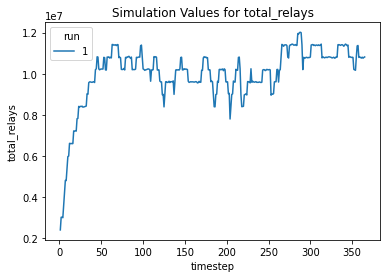

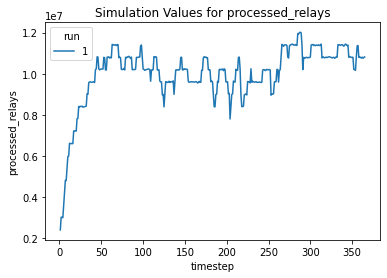

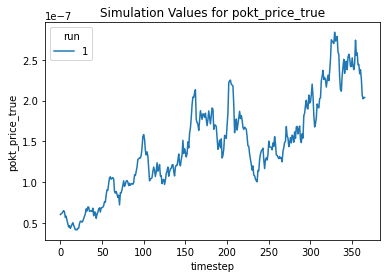

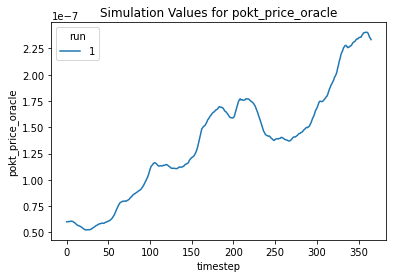

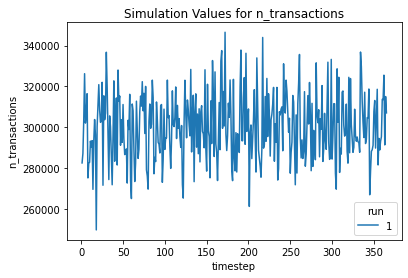

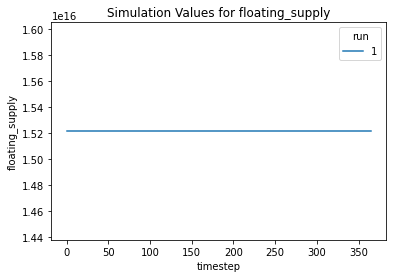

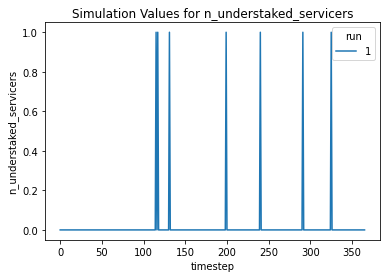

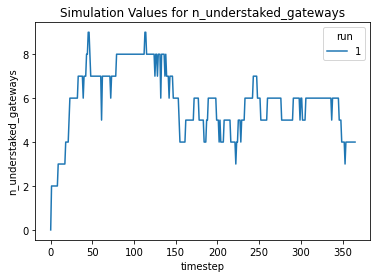

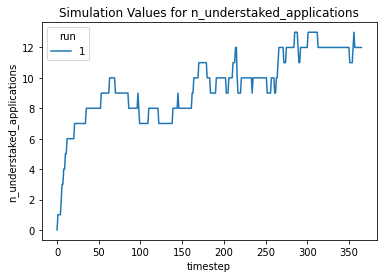

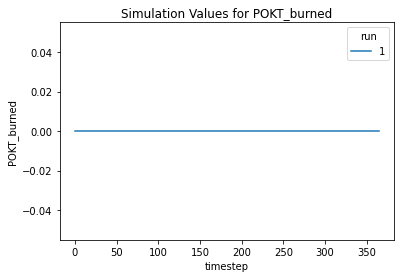

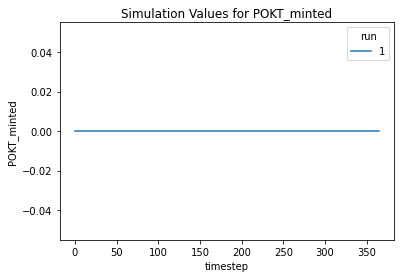

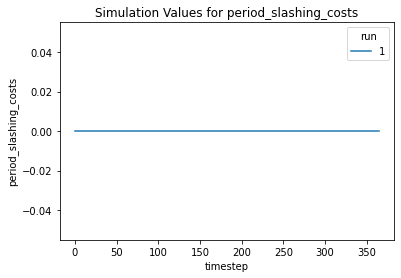

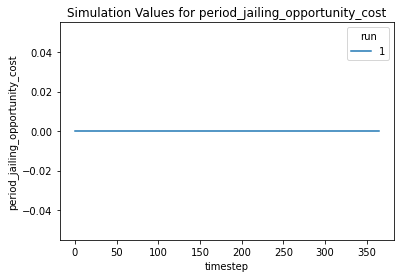

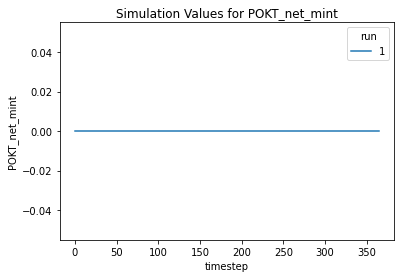

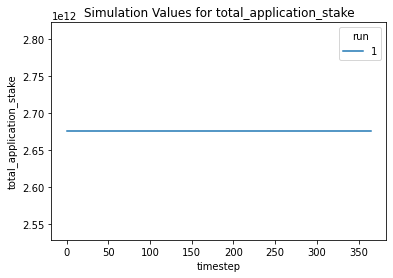

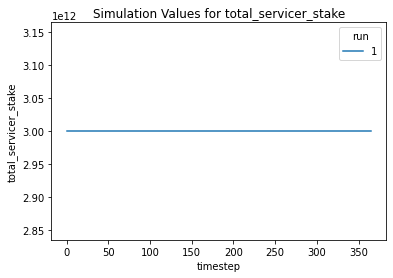

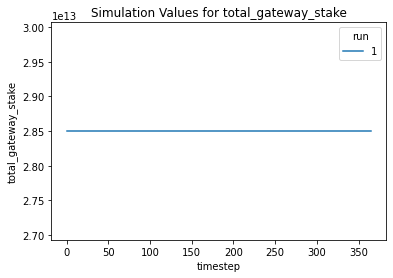

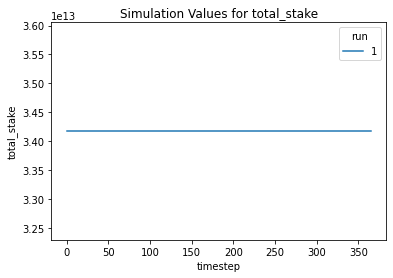

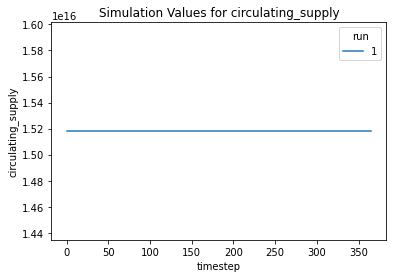

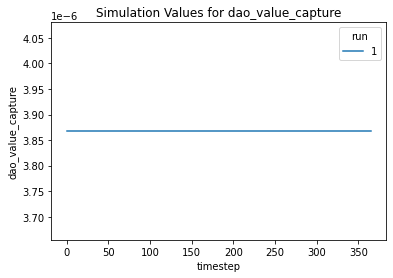

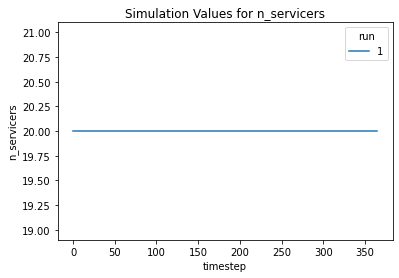

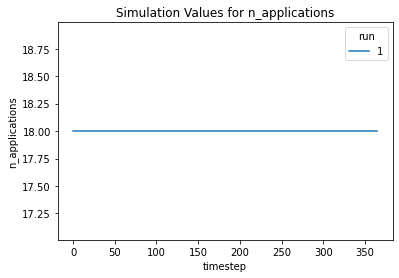

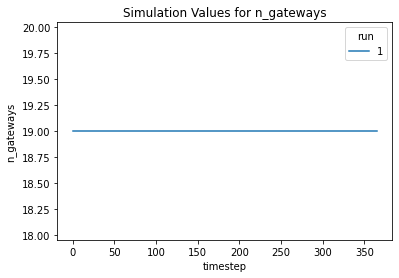

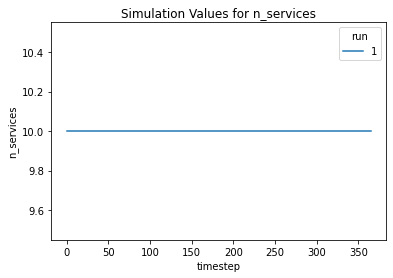

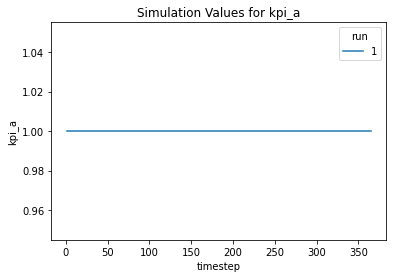

In [5]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a']:
    # Grab the pivot table
    table = df.pivot("timestep", "run", col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()